In [63]:

import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna.integration.lightgbm as lgb
import xgboost as xgb


from catboost import CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.base import clone


# 準備

In [19]:
"""データの読込"""
# 欠損値ありデータ
# train_df = pd.read_csv("../data/train.csv", index_col=0)
# test_df  = pd.read_csv("../data/test.csv", index_col=0)

# 欠損値なしデータ
train_df = pd.read_csv("../data/train_imputed_with_lgbm.csv", index_col=0)
test_df  = pd.read_csv("../data/test_imputed_with_lgbm.csv", index_col=0)

test_df.head()

,purpose,int.rate,installment,annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec
40785,2,0.1543,225.68,16525.86,22.39,668,1960,43771.0,59.3,3,0,0
40786,2,0.1539,200.43,62412.73,21.84,660,5958,13607.0,87.0,1,1,0
40787,2,0.1503,252.35,42836.79,21.77,663,4950,1832.0,36.8,5,0,1
40788,2,0.1316,533.85,27821.44,10.60,690,1825,3597.0,60.0,0,0,0
40789,2,0.1506,484.50,91406.09,17.35,658,3253,12137.0,48.8,1,0,0


In [3]:
"""データの基本情報"""

print(f"訓練データセットの形状： {train_df.shape}")
print(f"テストデータセットの形状： {test_df.shape}")

print()
print("===基本統計量===")
print("<訓練データセット>")
display(train_df.describe())
print("<最終テストデータセット>")
display(test_df.describe())


print()
print("===要約情報===")
print("<訓練データセット>")
display(train_df.info())
print("<最終テストデータセット>")
display(test_df.info())

訓練データセットの形状： (40785, 19)
テストデータセットの形状： (40786, 18)

===基本統計量===
<訓練データセット>


,purpose,int.rate,installment,annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose.kmeans_3,purpose.all_other_cluster,purpose.all_other_cluster.kmeans_3,inq.delinq.pub_risk,inq.delinq.pub_risk.kmeans_3,high_int.rate
count,40785.000000,40785.000000,40785.000000,4.078500e+04,40785.000000,40785.000000,40785.000000,40785.000000,40785.000000,40785.000000,40785.000000,40785.000000,40785.000000,40785.000000,40785.000000,40785.000000,40785.000000,40785.000000,40785.000000
mean,2.747628,0.125414,302.319235,7.087001e+04,12.530579,709.393061,4736.481746,15426.025468,46.161957,1.543018,0.180998,0.039696,0.151870,1.457399,4.511879,0.690916,1.763712,0.154003,0.000123
std,1.986736,0.030167,208.058959,6.524275e+04,6.831929,39.299297,2568.216636,22343.495560,28.258810,2.059082,0.513544,0.195246,0.358899,0.715350,2.378566,0.878474,2.187254,0.360956,0.011072
min,0.000000,0.060800,15.680000,2.086720e+03,0.110000,615.000000,179.000000,1.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.105300,157.400000,3.868640e+04,6.700000,679.000000,2965.000000,3433.000000,22.500000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,0.125200,241.120000,5.862029e+04,12.740000,703.000000,4304.000000,8441.000000,44.500000,1.000000,0.000000,0.000000,0.000000,2.000000,4.000000,0.000000,1.000000,0.000000,0.000000
75%,4.000000,0.145100,391.990000,8.416863e+04,17.930000,737.000000,5896.000000,19085.000000,68.900000,2.000000,0.000000,0.000000,0.000000,2.000000,6.000000,2.000000,3.000000,0.000000,0.000000
max,6.000000,0.800000,939.380000,1.913363e+06,29.930000,826.000000,16888.000000,356328.000000,108.300000,14.000000,3.000000,1.000000,1.000000,2.000000,8.000000,2.000000,17.000000,1.000000,1.000000


<最終テストデータセット>


,purpose,int.rate,installment,annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,purpose.kmeans_3,purpose.all_other_cluster,purpose.all_other_cluster.kmeans_3,inq.delinq.pub_risk,inq.delinq.pub_risk.kmeans_3,high_int.rate
count,40786.000000,40786.00000,40786.000000,4.078600e+04,40786.000000,40786.000000,40786.000000,40786.000000,40786.00000,40786.00000,40786.000000,40786.000000,40786.000000,40786.000000,40786.000000,40786.000000,40786.000000,40786.000000
mean,2.758888,0.12544,300.571366,7.019006e+04,12.552485,709.242338,4685.578556,15249.182289,46.41177,1.52876,0.179694,0.038739,1.459520,4.524616,0.689918,1.747193,0.151425,0.000172
std,1.980095,0.03087,208.171846,6.145846e+04,6.836684,39.320390,2540.021093,22272.133847,28.32093,2.08263,0.513398,0.192974,0.713822,2.372009,0.878961,2.207671,0.358467,0.013100
min,0.000000,0.06160,15.680000,2.128340e+03,0.090000,616.000000,181.000000,1.000000,0.10000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.10540,155.790000,3.855412e+04,6.700000,679.000000,2928.250000,3367.000000,23.00000,0.00000,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,0.12510,240.400000,5.814888e+04,12.760000,704.000000,4253.000000,8258.000000,44.70000,1.00000,0.000000,0.000000,2.000000,4.000000,0.000000,1.000000,0.000000,0.000000
75%,4.000000,0.14510,388.415000,8.379708e+04,17.950000,736.750000,5834.000000,18686.750000,69.10000,2.00000,0.000000,0.000000,2.000000,6.000000,2.000000,3.000000,0.000000,0.000000
max,6.000000,0.90000,938.860000,2.000790e+06,29.950000,826.000000,17416.000000,296156.000000,109.60000,14.00000,3.000000,1.000000,2.000000,8.000000,2.000000,16.000000,1.000000,1.000000



===要約情報===
<訓練データセット>
<class 'pandas.core.frame.DataFrame'>
Int64Index: 40785 entries, 0 to 40784
Data columns (total 19 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   purpose                             40785 non-null  int64  
 1   int.rate                            40785 non-null  float64
 2   installment                         40785 non-null  float64
 3   annual.inc                          40785 non-null  float64
 4   dti                                 40785 non-null  float64
 5   fico                                40785 non-null  int64  
 6   days.with.cr.line                   40785 non-null  int64  
 7   revol.bal                           40785 non-null  float64
 8   revol.util                          40785 non-null  float64
 9   inq.last.6mths                      40785 non-null  int64  
 10  delinq.2yrs                         40785 non-null  int64  
 11  pub.rec           

None

<最終テストデータセット>
<class 'pandas.core.frame.DataFrame'>
Int64Index: 40786 entries, 40785 to 81570
Data columns (total 18 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   purpose                             40786 non-null  int64  
 1   int.rate                            40786 non-null  float64
 2   installment                         40786 non-null  float64
 3   annual.inc                          40786 non-null  float64
 4   dti                                 40786 non-null  float64
 5   fico                                40786 non-null  int64  
 6   days.with.cr.line                   40786 non-null  int64  
 7   revol.bal                           40786 non-null  float64
 8   revol.util                          40786 non-null  float64
 9   inq.last.6mths                      40786 non-null  int64  
 10  delinq.2yrs                         40786 non-null  int64  
 11  pub.rec                

None

# 前処理

### 関数

In [4]:
def log_transform(x):
    return np.log(x)

In [20]:
"""データの変換（標準化・対数変換・OneHotエンコーディング）"""
# purpose
    # train
dummy_df = pd.get_dummies(
    train_df["purpose"],
    prefix="purpose",
    prefix_sep="_",
    drop_first=True, # k-1個のダミー変数を作成するかどうか（多重共線性の軽減）
)

# 列（横）方向に結合
train_df = pd.concat([train_df, dummy_df], axis=1).drop(columns="purpose")

    # test
dummy_df = pd.get_dummies(
    test_df["purpose"],
    prefix="purpose",
    prefix_sep="_",
    drop_first=True, # k-1個のダミー変数を作成するかどうか（多重共線性の軽減）
)

# 列（横）方向に結合
test_df = pd.concat([test_df, dummy_df], axis=1).drop(columns="purpose")

In [21]:
"""データの分割"""

# 説明変数/目的変数の分割
X = train_df.drop(columns=["not.fully.paid"])
y = train_df["not.fully.paid"]

# 訓練/テストデータに分割
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# モデルの構築

### 関数

In [83]:
"""構築された任意のモデルの出力が，閾値ごとにどう精度が変動するか？また，混同行列による可視化をする関数"""

def view_performance(
    model,
    X_train,
    X_test,
    y_train,
    y_test,
):
    # 1（未払い）である確率値を取得
    y_prob_train = model.predict_proba(X_train)[:, 1]
    y_prob_test = model.predict_proba(X_test)[:, 1]

    # 最もAUCスコアが高くなる閾値の取得&可視化
    best_thr = show_lineplt(
        y_prob_train=y_prob_train,
        y_prob_test=y_prob_test,
        y_train=y_train,
        y_test=y_test
    )

    # 混合行列の表示
    show_cm(
        best_thr=best_thr,
        y_prob_train=y_prob_train,
        y_prob_test=y_prob_test,
        y_train=y_train,
        y_test=y_test
    )



# 折れ線グラフ
def show_lineplt(
    y_prob_train,
    y_prob_test,
    y_train,
    y_test,
):
    # 0.1〜0.9の範囲の閾値に対するaucの変動の可視化
    thresholds = np.arange(0.1, 1.0, 0.1)

    # 各閾値におけるAUCスコアを格納するリスト
    auc_scores_train = []
    auc_scores_test = []

    # 最適な閾値を取得するための変数
    max_auc_score = 0
    best_thr = 0

    for thr in thresholds:
        # 閾値を上回る場合に1を割り当てる
        y_pred_train = (y_prob_train > thr).astype(int)
        y_pred_test = (y_prob_test > thr).astype(int)

        # AUCスコアの算出
        auc_train = roc_auc_score(y_true=y_train, y_score=y_pred_train)
        auc_test = roc_auc_score(y_true=y_test, y_score=y_pred_test)

        auc_scores_train.append(auc_train)
        auc_scores_test.append(auc_test)

        if auc_test > max_auc_score:
            max_auc_score = auc_test
            best_thr = thr

    # グラフのプロット
    plt.figure(figsize=(5, 5))
    plt.plot(thresholds, auc_scores_train, label="Train AUC score", color="blue")
    plt.plot(thresholds, auc_scores_test, label="Test AUC score", color="red")
    plt.xlabel("Threshold")
    plt.ylabel("AUC Score")
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_thr

def show_cm(
    best_thr,
    y_prob_train,
    y_prob_test,
    y_train,
    y_test,
):
    # 予測の二値化
    y_pred_train = (y_prob_train > best_thr).astype(int)
    y_pred_test = (y_prob_test > best_thr).astype(int)

    # 混合行列の作成
    conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=y_pred_train)
    conf_matrix_test = confusion_matrix(y_true=y_test, y_pred=y_pred_test)

    # 混合行列のヒートマッププロット
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # トレーニングデータの混合行列
    sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='binary', ax=axes[0])
    axes[0].set_title(f'Train Confusion Matrix\nThreshold = {best_thr}')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    # テストデータの混合行列
    sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='binary', ax=axes[1])
    axes[1].set_title(f'Test Confusion Matrix\nThreshold = {best_thr}')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

    # 混合行列の割合計算
    conf_matrix_train_norm = conf_matrix_train / conf_matrix_train.sum()
    conf_matrix_test_norm = conf_matrix_test / conf_matrix_test.sum()

    # 混合行列のヒートマッププロット
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # トレーニングデータの混合行列（割合）
    sns.heatmap(conf_matrix_train_norm, annot=True, fmt='.2%', cmap='binary', ax=axes[0])
    axes[0].set_title(f'Train Confusion Matrix (Normalized)\nThreshold = {best_thr}')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    # テストデータの混合行列（割合）
    sns.heatmap(conf_matrix_test_norm, annot=True, fmt='.2%', cmap='binary', ax=axes[1])
    axes[1].set_title(f'Test Confusion Matrix (Normalized)\nThreshold = {best_thr}')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

## LightGMB（データ不均衡のままversion）c

In [73]:
# チューニングするパラメータ
params = {
    "n_estimators": [650],
    "num_leaves": [3],
    "learning_rate": [0.05],
    "lambda_l1": [0.5],
    "lambda_2": [0],
    "verbosity": [-1],
}

# インスタンスの作成
lgbm = LGBMClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=params,
    cv=5,
    scoring='roc_auc'
)

# 最適なパラメータ探索
grid_search.fit(X_train, y_train)
display(pd.DataFrame(data=[grid_search.best_params_]))

,lambda_2,lambda_l1,learning_rate,n_estimators,num_leaves,verbosity
0,0,0.75,0.05,350,5,-1


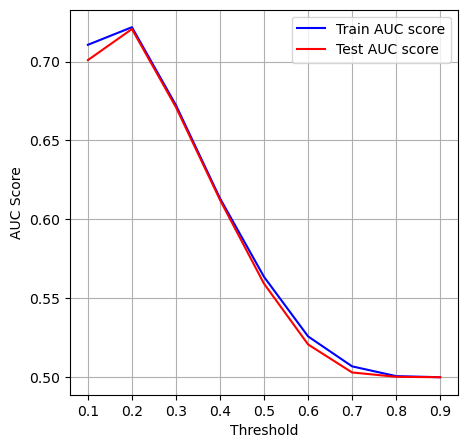

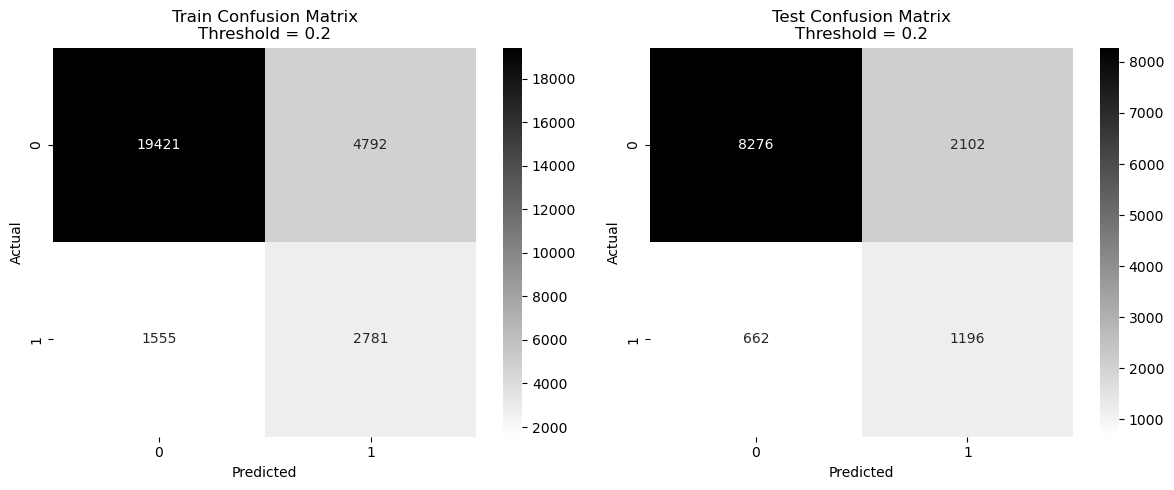

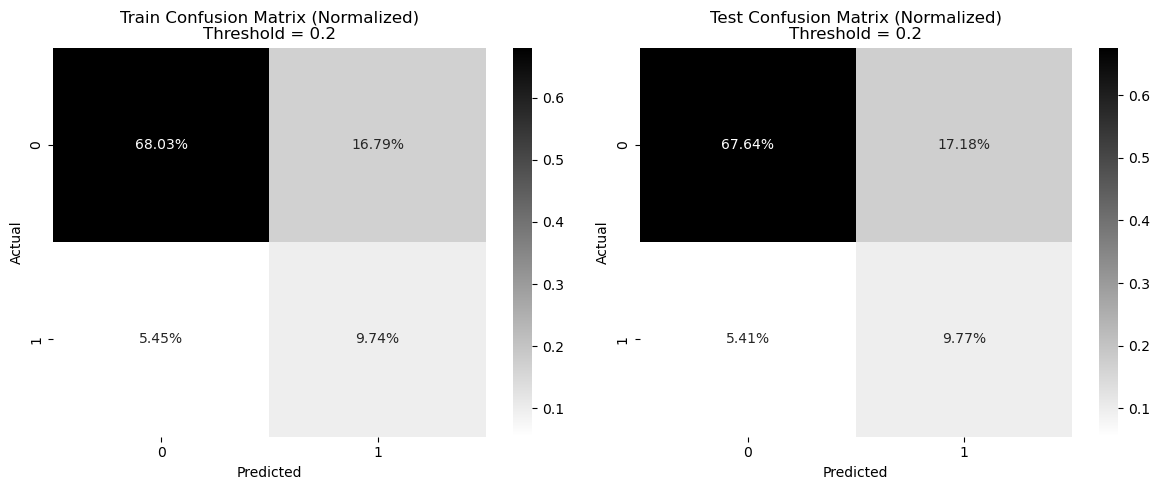

In [60]:
# モデル評価
view_performance(grid_search.best_estimator_)

### LightGBM（ラベル1に合わせてラベル0をアンダーサンプリングしたバギング）

In [81]:
# モデルのリストを保持するリスト
models_list = []

# LighGBMのパラメータ
params = {
    "n_estimators": 350,
    "num_leaves": 5,
    "learning_rate": 0.05,
    "lambda_l1": 0.75,
    "verbosity": -1,
    "random_state": 42,
}

# バギングのためのアンダーサンプリング回数
n_estimators = 50

for i in range(n_estimators):
    # 1 のサンプル数に0のサンプル数を合わせるアンダーサンプリング
    df_train = pd.concat([X_train, y_train], axis=1)
    df_majority = df_train[df_train["not.fully.paid"] == 0]
    df_minority = df_train[df_train["not.fully.paid"] == 1]

    # 少数クラスのサンプル数に多数クラスをランダムサンプリング
    df_majority_under = df_majority.sample(len(df_minority), random_state=42+i)

    # アンダーサンプリング後のデータフレーム
    df_under = pd.concat([df_majority_under, df_minority])

    # 説明変数と目的変数に分割
    X_train_under = df_under.drop(columns=["not.fully.paid"])
    y_train_under = df_under["not.fully.paid"]

    # モデルの構築
    lgbm = LGBMClassifier(random_state=42)
    lgbm.fit(X_train_under, y_train_under)

    # 訓練したモデルをリストに追加
    models_list.append((f'lightgbm_{i}', clone(lgbm)))

# バギングモデルの作成
voting_clf = VotingClassifier(estimators=models_list, voting="soft")

# バギングモデルの訓練
voting_clf.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 4336, number of negative: 4336
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2013
[LightGBM] [Info] Number of data points in the train set: 8672, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 4336, number of negative: 4336
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2007
[LightGBM] [Info] Number of data points in the train set: 8672, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 4336, number of negative: 

VotingClassifier(estimators=[('lightgbm_0', LGBMClassifier(random_state=42)),
                             ('lightgbm_1', LGBMClassifier(random_state=42)),
                             ('lightgbm_2', LGBMClassifier(random_state=42)),
                             ('lightgbm_3', LGBMClassifier(random_state=42)),
                             ('lightgbm_4', LGBMClassifier(random_state=42)),
                             ('lightgbm_5', LGBMClassifier(random_state=42)),
                             ('lightgbm_6', LGBMClassifier(random_sta...
                             ('lightgbm_23', LGBMClassifier(random_state=42)),
                             ('lightgbm_24', LGBMClassifier(random_state=42)),
                             ('lightgbm_25', LGBMClassifier(random_state=42)),
                             ('lightgbm_26', LGBMClassifier(random_state=42)),
                             ('lightgbm_27', LGBMClassifier(random_state=42)),
                             ('lightgbm_28', LGBMClassifier(random_state=42)),
                             ('lightgbm_29', LGBMClassifier(random_state=42)), ...],
                 voting='soft')

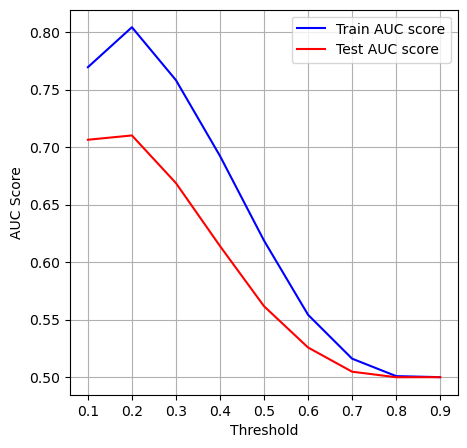

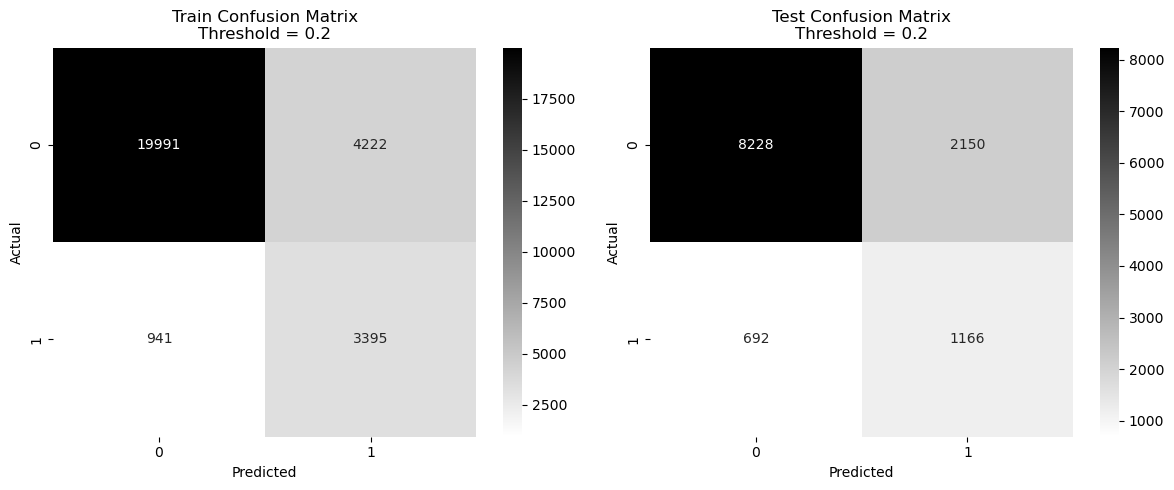

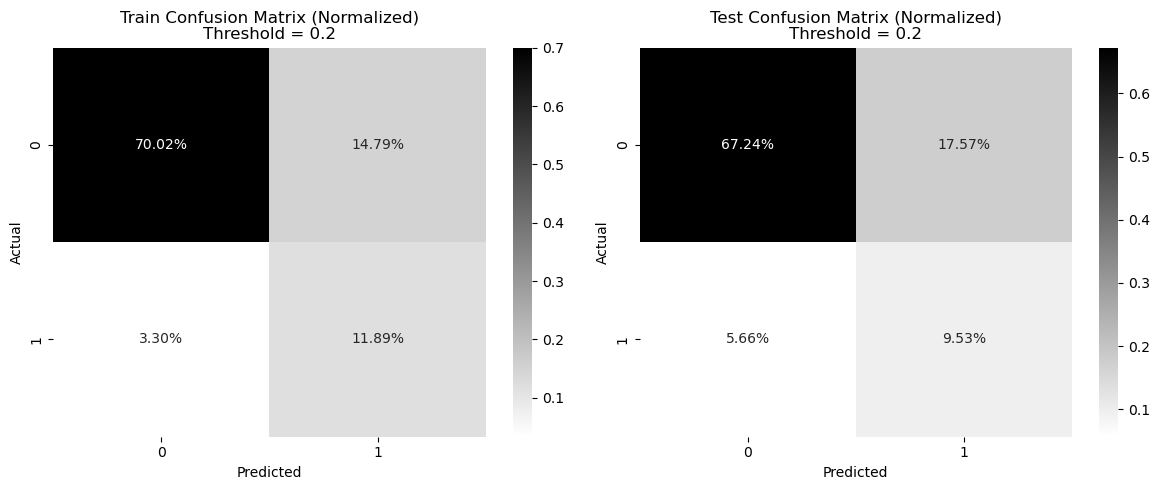

In [82]:
# モデル評価
view_performance(voting_clf)